In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split

import os
import matplotlib.pyplot as plt
import numpy as np

from model import MLP, MLP_RES, CNN_RES
from dataset import BurgersDataset, train_split_files
from config import (
    DATA_DIR,
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    EPOCHS,
    BATCH_SIZE,
    LR,
    SPLIT
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
train_files, val_files = train_split_files(data_dir=DATA_DIR, split=SPLIT)

train_dataset = BurgersDataset(file_paths=train_files)
val_dataset = BurgersDataset(file_paths=val_files)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Found 3 simulations.
Splitting into 1 training and 2 validation files.


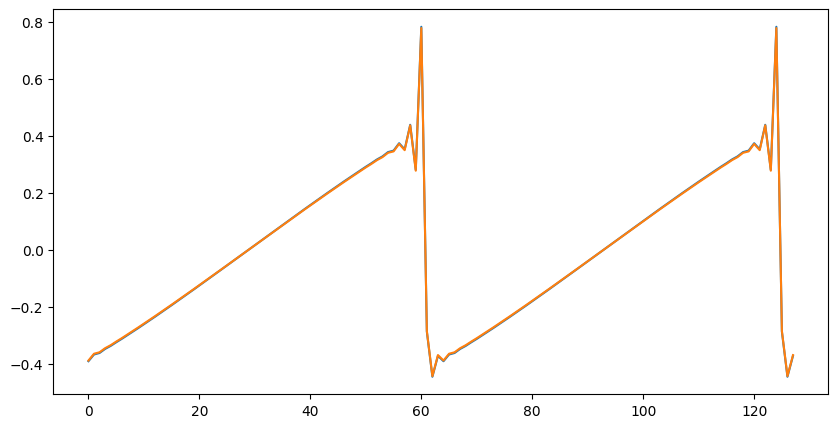

In [40]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample
#plot 
plt.figure(figsize=(10,5))
plt.plot(x[0].numpy(), label='Input')
plt.plot(y[0].numpy(), label='Target')

In [10]:
from model import pad_with_ghost_cells
def train(criterion, optimizer, scheduler, model, train_loader, val_loader, device):

    best_val_loss = float("inf")
    loss_history = {"train": [], "val": []}
    print("Starting training...")

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            bc_left = x[:, -1:]
            bc_right = x[:, :1]

            padded_input = pad_with_ghost_cells(x, bc_left, bc_right)

            optimizer.zero_grad()
            y_pred = model(padded_input)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)

                bc_left = x[:, -1:]
                bc_right = x[:, :1]

                padded_input = pad_with_ghost_cells(x, bc_left, bc_right)

                y_pred = model(padded_input)
                val_loss += criterion(y_pred, y).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"New best model found at epoch {epoch+1} with val loss {best_val_loss:.6f}")
        
        # Get the current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']
        
        print(
            f"Epoch {epoch+1}/{EPOCHS}, "
            f"Train Loss: {avg_train:.6f}, "
            f"Val Loss: {avg_val:.6f}, "
            f"LR: {current_lr:.8f}"
        )

        loss_history["train"].append(avg_train)
        loss_history["val"].append(avg_val)

        # Step the scheduler at the end of each epoch
        scheduler.step()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    print("Finished training.")

    return loss_history

In [11]:
model = MLP_RES(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-8)

if not os.path.exists("models/MLP_RES.pth"):
    loss_history = train(criterion, optimizer, scheduler, model, train_loader, val_loader, device)
    torch.save(model.state_dict(), "models/MLP_RES.pth")
    print(f"Model saved")
else:
    model.load_state_dict(torch.load("models/MLP_RES.pth"))
    model.eval()
    print("Model loaded")

Assuming ghost cells
Starting training...
New best model found at epoch 1 with val loss 0.011144
Epoch 1/100, Train Loss: 0.013455, Val Loss: 0.011144, LR: 0.00010000
New best model found at epoch 2 with val loss 0.010324
Epoch 2/100, Train Loss: 0.009278, Val Loss: 0.010324, LR: 0.00009998
New best model found at epoch 3 with val loss 0.010099
Epoch 3/100, Train Loss: 0.008692, Val Loss: 0.010099, LR: 0.00009990
New best model found at epoch 4 with val loss 0.009783
Epoch 4/100, Train Loss: 0.008294, Val Loss: 0.009783, LR: 0.00009978
New best model found at epoch 5 with val loss 0.009720
Epoch 5/100, Train Loss: 0.007999, Val Loss: 0.009720, LR: 0.00009961
New best model found at epoch 6 with val loss 0.009428
Epoch 6/100, Train Loss: 0.007665, Val Loss: 0.009428, LR: 0.00009938
New best model found at epoch 7 with val loss 0.009182
Epoch 7/100, Train Loss: 0.007350, Val Loss: 0.009182, LR: 0.00009911
Epoch 8/100, Train Loss: 0.007097, Val Loss: 0.009394, LR: 0.00009880
New best mode

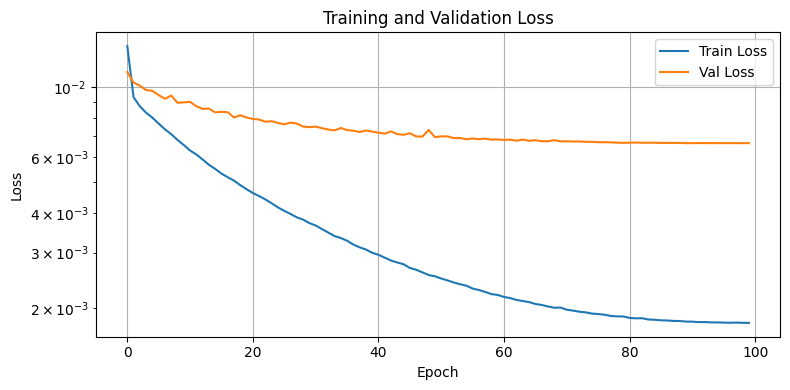

In [12]:
if loss_history:
    plt.figure(figsize=(8, 4))
    plt.plot(loss_history["train"], label="Train Loss")
    plt.plot(loss_history["val"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.yscale("log")
    plt.tight_layout()
    plt.grid()
    plt.legend()
    plt.show()

In [13]:
NUM_RES_BLOCKS = 4
KERNEL_SIZE = 5

model = CNN_RES(
    hidden_channels=HIDDEN_SIZE,
    num_blocks=NUM_RES_BLOCKS,
    kernel_size=KERNEL_SIZE
)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-8)

if not os.path.exists("models/CNN_RES.pth"):
    loss_history = train(criterion, optimizer, scheduler, model, train_loader, val_loader, device)
    torch.save(model.state_dict(), "models/CNN_RES.pth")
    print(f"Model saved")
else:
    model.load_state_dict(torch.load("models/CNN_RES.pth"))
    model.eval()
    print("Model loaded")

Starting training...
New best model found at epoch 1 with val loss 0.018999
Epoch 1/100, Train Loss: 0.057610, Val Loss: 0.018999, LR: 0.00010000
New best model found at epoch 2 with val loss 0.008473
Epoch 2/100, Train Loss: 0.013622, Val Loss: 0.008473, LR: 0.00009998
New best model found at epoch 3 with val loss 0.007106
Epoch 3/100, Train Loss: 0.013221, Val Loss: 0.007106, LR: 0.00009990
Epoch 4/100, Train Loss: 0.008583, Val Loss: 0.007978, LR: 0.00009978
New best model found at epoch 5 with val loss 0.004672
Epoch 5/100, Train Loss: 0.008583, Val Loss: 0.004672, LR: 0.00009961
New best model found at epoch 6 with val loss 0.001815
Epoch 6/100, Train Loss: 0.008138, Val Loss: 0.001815, LR: 0.00009938
Epoch 7/100, Train Loss: 0.008079, Val Loss: 0.002714, LR: 0.00009911
Epoch 8/100, Train Loss: 0.008139, Val Loss: 0.003222, LR: 0.00009880
Epoch 9/100, Train Loss: 0.006625, Val Loss: 0.004437, LR: 0.00009843
New best model found at epoch 10 with val loss 0.001385
Epoch 10/100, Trai

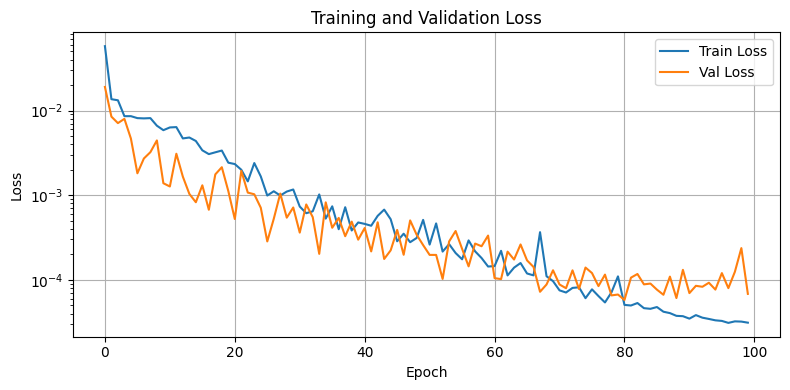

In [14]:
if loss_history:
    plt.figure(figsize=(8, 4))
    plt.plot(loss_history["train"], label="Train Loss")
    plt.plot(loss_history["val"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.yscale("log")
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.show()

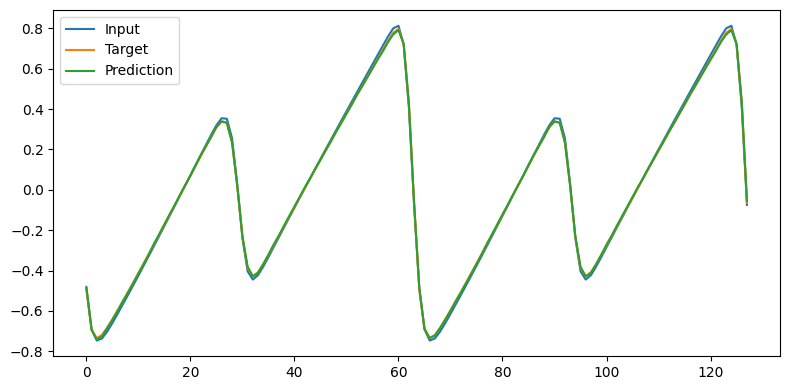

In [29]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample

x = x.to(device)
y = y.to(device)

with torch.no_grad():
    bc_left = x[:, -1:]
    bc_right = x[:, :1]
    padded_input = pad_with_ghost_cells(x, bc_left, bc_right)
    y_pred = model(padded_input)

y_pred = y_pred.cpu()
x = x.cpu()
y = y.cpu()
#plot 
plt.figure(figsize=(8,4))
plt.plot(x[0].numpy(), label='Input')
plt.plot(y[0].numpy(), label='Target')
plt.plot(y_pred[0], label='Prediction')
plt.tight_layout()
plt.legend()

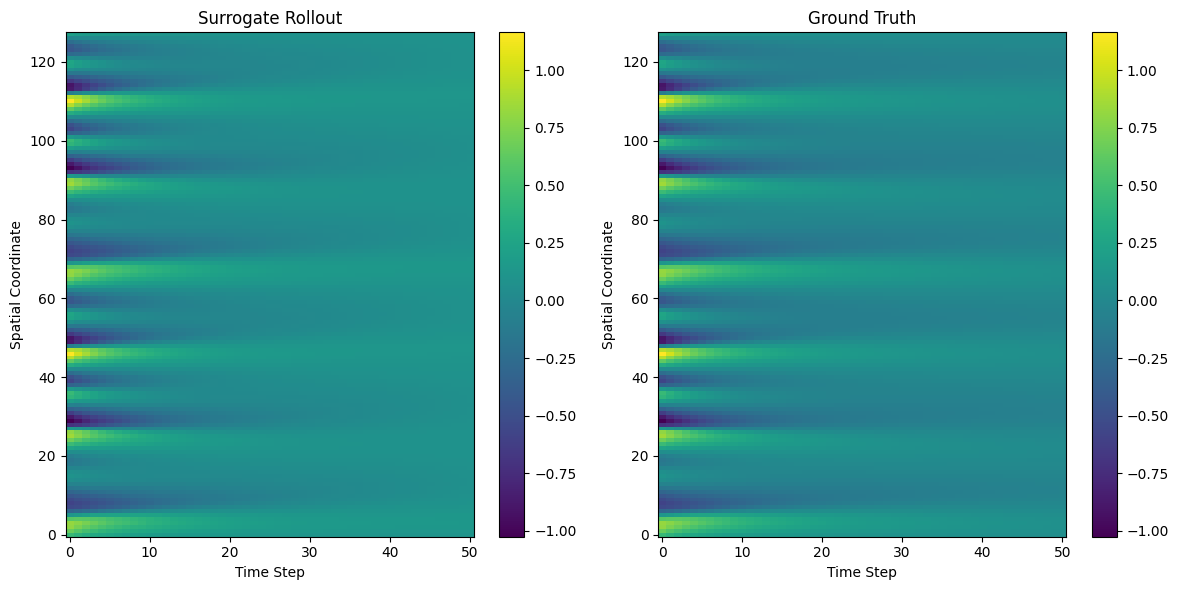

Corrected Rollout MSE over 50 steps: 0.0034


In [42]:
import numpy as np
import os

model.eval()

npz_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.npz')]
if not npz_files:
    print("No .npz files found for evaluation.")
    
file_num = np.random.randint(0, len(npz_files) - 1)
data_path = os.path.join(DATA_DIR, npz_files[file_num])
raw_data = np.load(data_path)['Solver-Mesh-1D-Internal']

rollout_steps = raw_data.shape[0] - 1
rollout_steps //= 2

start_index = 3

x0_np = raw_data[start_index]
ground_truth = raw_data[start_index : start_index + rollout_steps + 1]

predictions = [x0_np]
current_x = torch.from_numpy(x0_np).float().unsqueeze(0)

with torch.no_grad():
    for _ in range(rollout_steps):
        current_x = current_x.to(device)
        bc_left = current_x[:, -1:]
        bc_right = current_x[:, :1]
        padded_input = pad_with_ghost_cells(current_x, bc_left, bc_right)
        y_pred = model(padded_input)
        predictions.append(y_pred.squeeze().cpu())
        current_x = y_pred

predictions = np.array(predictions)

vmin = ground_truth.min()
vmax = ground_truth.max()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(predictions.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Surrogate Rollout')
plt.xlabel('Time Step')
plt.ylabel('Spatial Coordinate')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(ground_truth.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Ground Truth')
plt.xlabel('Time Step')
plt.ylabel('Spatial Coordinate')
plt.colorbar()

plt.tight_layout()
plt.savefig('rollout_comparison.png')
plt.show()

mse = np.mean((predictions - ground_truth)**2)
print(f"Corrected Rollout MSE over {rollout_steps} steps: {mse:.4f}")

In [17]:
!jupyter nbconvert --to script train_burgers.ipynb

[NbConvertApp] Converting notebook train_burgers.ipynb to script
[NbConvertApp] Writing 7522 bytes to train_burgers.py
